In [60]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import os

os.chdir("..")

linestyles = ["-", "--", ":"]

In [61]:
class ExpInfo:
    def __init__(self):
        pass
    
class ExpDB:
    globber = "**/new_metrics_*.pkl"
    def __init__(self, data=[], dir_path=None):
        assert data == [] or dir_path is None
        if dir_path is not None:
            self.data = []
            for path in Path(dir_path).glob(self.globber):
                self.add_from_path(path)
        else:
            self.data = data
    
    def add_from_path(self, path):
        name = path.stem
        mode, max_len, pred_size = path.parent.name.split("_")
        test_set_size, n_samples, T_pred = name.split("_")[-1].split("-")
        max_len, pred_size, test_set_size, n_samples, T_pred = map(int, [max_len, pred_size, test_set_size, n_samples, T_pred])
        config = dict(mode=mode, max_len=max_len, pred_size=pred_size,
                      test_set_size=test_set_size, n_samples=n_samples,
                      T_pred=T_pred)
        metrics = pickle.load(open(path, "rb"))
        self.data.append({"path": path,
                          "config": config,
                          "metrics": metrics})
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __iter__(self):
        return iter(self.data)
    
    def query(self, **kwargs):
        return ExpDB([x for x in self.data if all([x["config"][k] == v for (k,v) in kwargs.items()])])

    def sort(self, keys):
        if isinstance(keys, str):
            self.sort([keys])
        self.data.sort(key=lambda x: [x["config"][k] for k in keys])
        
    def get_sorted(self, keys):
        if isinstance(keys, str):
            return self.get_sorted([keys])
        return ExpDB(data=sorted(self.data, key=lambda x: [x["config"][k] for k in keys]))
        
    def print_config(self):
        for x in self.data:
            print(x["config"])
            

class ElboDB(ExpDB):
    globber = "**/elbo_*.pkl"
    def __init__(self, data=[], dir_path=None):
        assert data == [] or dir_path is None
        if dir_path is not None:
            self.data = []
            for path in set(path.parent for path in Path(dir_path).glob(self.globber)):
                self.add_from_path(path)
        else:
            self.data = data

    def add_from_path(self, path):
        i = 0
        data = None
        while os.path.exists(path / f"elbo_{i}.pkl"):
            data_i = pickle.load(open(path / f"elbo_{i}.pkl", 'rb'))
            if i == 0:
                data = {k: [] for k in data_i}
            for k in data:
                data[k].append(data_i[k])
            i += 1
        data = {k: np.stack(v, axis=0) for k, v in data.items()}
        self.data.append({"path": path,
                          "config": None,
                          "metrics": data})

## NLLs for varying max_frames

In [42]:
T160_db = ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/T160-200k-iters/')

def first_n(array, n):
    assert len(array) >= n
    return array[:n]

def label_func(path):
    modes = {
        '12b3f0tz': ('Mazes', 'full video'),
        '3d4unb1k': ('Mazes', 'ours'),
        '34crrvr8': ('MineRL', 'full video'),
        '30v09jjq': ('MineRL', 'ours'),}
    sample_settings = path.parts[-1]
    sample_mode, max_frames, *_ = sample_settings.split('_')
    id = path.parts[-2]
    dataset, method = modes[id]
    label = f"{method} on {dataset}"
    if int(max_frames) == 160:
        label += " (generated at once)"
    else:
        label = label + f" (with {sample_mode}, max {max_frames} frames)"
    return label

to_show = {}
for run in T160_db:
    elbo = first_n(run['metrics']['total_bpd'], 100).sum(axis=1).mean(axis=0)
    label = label_func(run['path'])
    to_show[label] = elbo

def print_things(dataset):
    for k, v in sorted(to_show.items(), key=lambda x: x[1]):
        if dataset in k:
            print(f"{v:.2f} - {k}")
            
print_things('MineRL')
print()
print_things('Mazes')

798.75 - full video on MineRL (generated at once)
800.21 - ours on MineRL (generated at once)
919.78 - ours on MineRL (with hierarchy-2, max 20 frames)
919.87 - ours on MineRL (with hierarchy-2, max 40 frames)
920.12 - ours on MineRL (with hierarchy-2, max 80 frames)

803.09 - full video on Mazes (generated at once)
805.94 - ours on Mazes (generated at once)
941.54 - ours on Mazes (with hierarchy-2, max 80 frames)
941.95 - ours on Mazes (with hierarchy-2, max 40 frames)
942.07 - ours on Mazes (with hierarchy-2, max 20 frames)


## Test ELBOs for some ablations (all trained for 400k iterations on Mazes with T=300 and computed on masks sampled from our training distribution)

In [45]:
main_db = ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/second-batch-400k-iters/')

def label_func(path):
    modes = {
        '3kdr4q5k': 'Ours',
        '3kd38zvf': 'No padding with random frames',
        '8aj6rgym': 'With global frame encoding',
        }
    id = path.parts[-2]
    return modes[id]

ablations = [run for run in main_db if 'differently-spaced-groups' in str(run['path'])]
for run in ablations:
    elbo = first_n(run['metrics']['total_bpd'], 100).sum(axis=1).mean(axis=0)
    print(f"{elbo:.2f} - {label_func(run['path'])}")

38.78 - Ours
39.05 - No padding with random frames
38.74 - With global frame encoding


## Test ELBOs for various different inference modes (all from same network trained for 400k iterations on Mazes with T=300)

In [59]:
inf_modes = [run for run in main_db if 'differently-spaced-groups' not in str(run['path'])]

def label_func(path):
    id = path.parts[-2]
    assert id == '3kdr4q5k'
    return path.parts[-1]


for run in inf_modes:
    metrics = run['metrics']
    path = run['path']
    print(metrics['total_bpd'][:2])
    elbo = first_n(metrics['total_bpd'], 100).sum(axis=1).mean(axis=0)
    print(f"{elbo:.2f} - {label_func(run['path'])}")

[[52.902294 55.104523 53.31106  53.05717  54.346535 54.369514 54.358616
  54.12442  53.138435 53.415512 52.371143 50.66043  46.66011   8.452689]
 [54.7554   53.281364 54.155037 53.670403 54.035946 54.612026 54.88136
  53.633133 55.53963  54.61596  53.820557 53.00612  50.762917  8.377924]]
699.44 - really-independent_20_10_300_36
[[64.509094 64.979485 65.33585  65.62654  65.59074  64.82095  64.713104
  64.98865  65.34053  65.47204  65.306885 65.60179  65.62818  65.70948
  65.17047  65.38373  65.32353  64.986015 65.113556 65.07243  65.37638
  64.54469  64.56729  63.64424  62.529713 63.114258 25.185751]
 [64.59406  64.00655  63.596245 64.23475  64.29798  63.88744  64.62099
  64.86133  64.91841  64.81074  64.8803   64.64514  64.26223  64.870026
  65.00927  64.167    64.7103   64.452545 64.703674 65.07471  65.15889
  64.77936  64.44502  64.90781  63.674854 64.41909  24.644873]]
1714.11 - mixed-autoreg-independent_20_10_300_36
[[65.36181  65.08416  65.319664 65.58458  66.04746  65.618866 64.

## NLLs for ablation on RPE net (https://wandb.ai/universal-conditional-ddpm/video-diffusion/sweeps/zrexk7n3)

In [71]:
with_rpe_db =  ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/with-rpe-net-differently-spaced-groups/')
without_rpe_db =  ElboDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/without-rpe-net-differently-spaced-groups/')


print('With RPE')
for run in with_rpe_db:
    elbo = first_n(run['metrics']['total_bpd'], 32).sum(axis=1).mean(axis=0)
    print(elbo)

print('Without RPE')
for run in without_rpe_db:
    elbo = first_n(run['metrics']['total_bpd'], 32).sum(axis=1).mean(axis=0)
    print(elbo)

With RPE
24.482132
24.476505
Without RPE
24.478382
24.48713
24.487183


In [50]:
# metrics_db.sort(["mode", "pred_size", "n_samples"])
metrics_db = ExpDB(dir_path='/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion')

In [51]:
metrics_db.print_config()

{'mode': 'autoreg', 'max_len': 20, 'pred_size': 10, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 10}
{'mode': 'autoreg', 'max_len': 20, 'pred_size': 10, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'autoreg', 'max_len': 20, 'pred_size': 10, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 300}
{'mode': 'independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 300}
{'mode': 'hierarchy-2', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 300}
{'mode': 'mixed-autoreg-independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'mode': 'mixed-autoreg-independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 300}
{'mode': 'really-independent', 'max_len': 10, 'pred_size': 5, 'test_set_size': 104, 'n_samples': 2, 'T_pred': 264}
{'m

In [32]:
for run in metrics_db:
    if run['config']['mode'] == 'hierarchy-3':
        print(run['path'])

/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/3qss4oyd/hierarchy-3_20_10/new_metrics_104-5-300.pkl
/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/3qss4oyd/hierarchy-3_20_10/new_metrics_104-2-300.pkl


In [33]:
_default_label_func = lambda x: f"{x['path'].parent.name}/{x['path'].stem}"


def do_plot(db, ax, mode, errorbar=True,
            label_func=_default_label_func,
            agg_mode="best",
            baseline_metrics=None, set_color=None,
            verbose=True):
    
    def agg_predictions(metric, agg_mode):
        assert agg_mode in ["best", "best_avg", "mean", "random"]
        best_fn = {"ssim": "max", "psnr": "max", "lpips": "min"}[mode]

        if agg_mode == "best":
            metric = getattr(metric[:, :2], best_fn)(axis=1)
        elif agg_mode == "best_avg":
            # Finding the order within samples wrt avg metric across time.
            order_metric = np.argsort(np.mean(metric, -1), axis=-1)
            assert best_fn in ["max", "min"]
            if best_fn == "max":
                metric = np.stack([metric[i, order[-1]] for (i, order) in enumerate(order_metric)])
            else:
                metric = np.stack([metric[i, order[0]] for (i, order) in enumerate(order_metric)])
        elif agg_mode == "random":
            metric = metric[:, 0, :]
        elif agg_mode == "mean":
            metric = metric.mean(axis=1)
        else:
            raise ValueError(f"Unknown aggregation mode {agg_mode}")
        return metric
    
    labels_seen = set()
    assert mode in ["ssim", "psnr", "lpips"]
    if label_func is None:
        label_func = lambda x: None
    for exp_data in db:
        path = str(exp_data["path"])
        metrics = exp_data["metrics"]
        if mode not in metrics:
            if verbose:
                print(f"Metrics {mode} not found in {path}")
            continue
        metric = agg_predictions(metrics[mode], agg_mode)

        mean = metric.mean(axis=0)
        std = metric.std(axis=0)
        label = None
        ls = '-'
        label = label_func(exp_data)
        
        color = set_color(path) if set_color is not None else None

        ax.plot(mean, label=None if label in labels_seen else label, color=color, ls=ls)
        labels_seen.add(label)
        if errorbar:
            ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1)
    ax.grid("on")

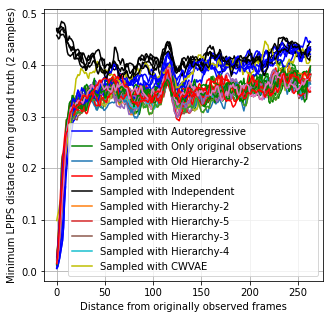

In [34]:
import wandb

class WandbRunNames(dict):
    def __init__(self):
        self.api = wandb.Api()
        self['cwvae'] = 'cwvae'
        
    def __getitem__(self, id):
        if id in self:
            return super().__getitem__(id)
        else:
            name = self.api.run(f"universal-conditional-ddpm/video-diffusion/{id}").name
            self[id] = name
            return name

run_names = WandbRunNames()

nice_mode_names = {
    'autoreg': 'Autoregressive',
    'independent': 'Only original observations',
    'mixed-autoreg-independent': 'Mixed',
    'hierarchy-2': 'Old Hierarchy-2',
    'hierarchy-2-new': 'Hierarchy-2',
    'hierarchy-3': 'Hierarchy-3',
    'hierarchy-4': 'Hierarchy-4',
    'hierarchy-5': 'Hierarchy-5',
    'really-independent': 'Independent',
    'cwvae': 'CWVAE',
}

def pad_to_len(s, l):
    return s + ' '*max(0, l-len(s))

def label_func(x):
    id = x['path'].parts[-3]
    return f"Sampled with {pad_to_len(nice_mode_names[x['config']['mode']], 30)}" #" - Trained with '{run_names[id]}'"


def set_color(path):
    if 'mixed' in path:
        return 'r'
    elif 'autoreg' in path:
        return 'b'
    elif 'really-independent' in path:
        return 'k'
    elif 'independent' in path:
        return 'g'
    elif 'cwvae' in path:
        return 'y'
fig, ax = plt.subplots(figsize=(5, 5))
do_plot(metrics_db, ax, mode='lpips', errorbar=False, set_color=set_color,
       label_func=label_func, verbose=False)
ax.set_xlabel('Distance from originally observed frames')
ax.set_ylabel('Minimum LPIPS distance from ground truth (2 samples)')
ax.legend()

## FVD

In [35]:
fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in metrics_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
for fvd, run in fvds_runs:
    if 'hierarchy-2_' in str(run['path']):
        continue
    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
    id = run['path'].parts[-3]
    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 40)} Trained with {run_names[id]}")

38.41 +- 3.6 (2 seeds) - Sampled with Hierarchy-3                    Trained with predict 20 frames out of 300
40.93 +- 0.5 (2 seeds) - Sampled with Hierarchy-4                    Trained with predict 20 frames out of 300
41.14 +- 2.3 (5 seeds) - Sampled with Hierarchy-2                    Trained with predict 20 frames out of 300
41.17 +- 5.0 (5 seeds) - Sampled with Hierarchy-3                    Trained with predict 20 frames out of 300
41.49 +- 2.3 (2 seeds) - Sampled with Hierarchy-2                    Trained with predict 20 frames out of 300
41.71 +- 2.0 (5 seeds) - Sampled with Hierarchy-4                    Trained with predict 20 frames out of 300
46.33 +- 3.5 (5 seeds) - Sampled with Hierarchy-5                    Trained with predict 20 frames out of 300
48.44 +- 4.5 (2 seeds) - Sampled with Hierarchy-5                    Trained with predict 20 frames out of 300
50.24 +- 2.3 (2 seeds) - Sampled with Mixed                          Trained with predict 20 frames out of 300
5

In [21]:
mixed_db = [thing for thing in metrics_db if 'mixed' in str(thing['path'])]
autoreg_db = [thing for thing in metrics_db if 'autoreg_' in str(thing['path']) and 'mixed' not in str(thing['path'])]
independent_db = [thing for thing in metrics_db if 'independent_' in str(thing['path']) and 'mixed' not in str(thing['path'])]

## Autoreg

Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/8ivr9017/autoreg_20_10/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/1hceexne/autoreg_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/164s19am/autoreg_36_4/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/3qss4oyd/autoreg_20_10/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/2sj8w2qr/autoreg_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/1vmoisia/autoreg_40_20/new_metrics_112-2-300.pkl
Metrics

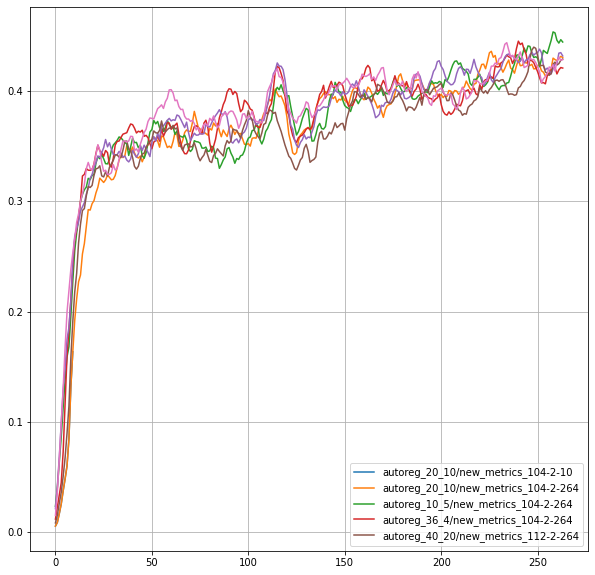

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(autoreg_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Mixed

Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/1hceexne/mixed-autoreg-independent_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/3qss4oyd/mixed-autoreg-independent_20_10/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/2sj8w2qr/mixed-autoreg-independent_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/oek2coit/mixed-autoreg-independent_40_20/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/35k0jair/mixed-autoreg-independent_20_10/new_metrics_104-2-300.pkl


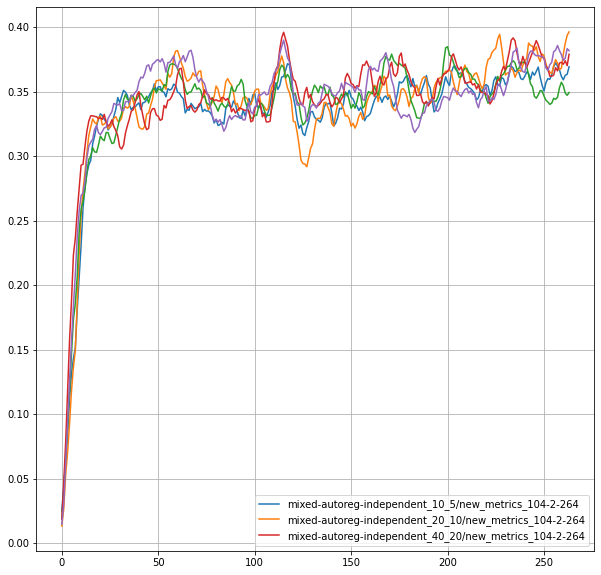

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(mixed_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Independent

Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/1hceexne/independent_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/1hceexne/really-independent_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/3qss4oyd/independent_20_10/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/2sj8w2qr/independent_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/2sj8w2qr/really-independent_10_5/new_metrics_104-2-300.pkl
Metrics lpips not found in /home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/samples/5day-runs/oek2coit/independent_40

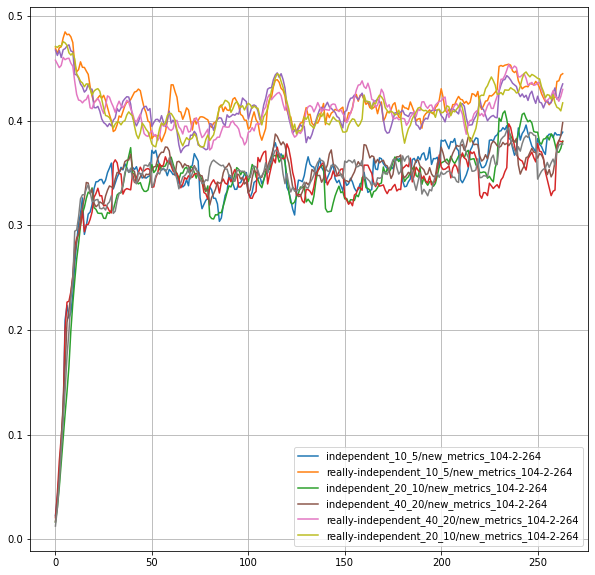

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(independent_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()